# Virtual ADC example
---


## Load the bitstream into the Programmable Logic

In [11]:
%reload_ext autoreload
%autoreload 2
# Import the X-HEEP Python class
from pynq import x_heep
# Allow the import of all modules in this directory
import sys
import os

SDK_PATH = "/home/xilinx/x-heep-femu-sdk/"
RISCV_PATH = 'sw/riscv/'
APP_PATH = SDK_PATH + RISCV_PATH + 'apps/adc-emu/'
ADC_BIN_NAME = 'adc_in'

sys.path.append(SDK_PATH + "sw/arm/apps/adc-emu/src")

from timeseries import *

# Load the X-HEEP bitstream
xh = x_heep()

## Generate an input array to use as signal 

In [12]:
import numpy as np
from timeseries import Timeseries

MAX_POSSIBLE_DATA_LENGTH    = 2048
INPUT_DATA_LENGTH           = 800

# Generate a binary file from a txt
if 0:
    with open( APP_PATH + 'EpiPhone.txt', 'r') as f: 
        din = f.readlines()

    # Keep only the first few values
    din_f = din[:INPUT_DATA_LENGTH]
    din_f = np.array(din_f, dtype=float)

    # Don't normalize, just round to u16
    din_u16 = din_f.astype(np.uint16)

    # Save the array to a binary file
    din_norm_u32 = din_u16.astype(np.uint32).copy()
    with open(APP_PATH + ADC_BIN_NAME + "bin",'wb') as file:
        din_norm_u32.byteswap(True).tofile(file)


# Take a pre-generated binary file
if 1: 
    src         = SDK_PATH + 'sw/arm/apps/adc-emu/out/'
    src_name    = 'Raw_Norm'
    ext_bin     = '.bin'
    ext_pkl     = '.pkl'
    dst         = APP_PATH
    dst_name    = ADC_BIN_NAME

    din = Timeseries.load(src+src_name+ext_pkl)
    din.data += abs(min(din.data))
    din.export_bin(path=APP_PATH, name=ADC_BIN_NAME)

    INPUT_DATA_LENGTH = len(din.data)



## Compile the code and run the application
You can change the variable `SKIP_COMPILE`  to 1 to avoid compiling each time.

You can change the variable `SKIP_MEMORY`   to 1 to avoid generating the ADC memory each time.

You can change the variable `VERBOSE`       to 0 to supress the live printing of the UART.

In [13]:
# Skip compiling if all you want to do is run the application
# Note that the compilation is affected by the parameters written to the definitions.h file
SKIP_COMPILE    = 0
# Skip the memory generation
SKIP_MEMORY     = 0
# Wether to see the X-HEEP UART output live.
VERBOSE         = 0
# Enable the printfs inside X-HEEP application. This is not the same as VERBOSE, as it actually reflects in C-code and therefore in performance.
ENABLE_PRINTF   = 1



# Write the definitions header file to share information with the C code
defs = APP_PATH + 'definitions.h'
xh.open_definitions (defs, "DEFINITIONS")
xh.add_definition   (defs, "INPUT_DATA_LENGTH", INPUT_DATA_LENGTH)
xh.add_definition   (defs, "ENABLE_PRINTF",     ENABLE_PRINTF)
xh.close_definitions (defs)


# Compile the application
if SKIP_COMPILE or xh.compile_app("adc-emu"):

    if not SKIP_MEMORY:
        # Write the ADC data to the virtual ADC
        adc = xh.init_adc_mem() # Init the ADC memory
        xh.reset_adc_mem(adc)   # Reset the ADC memory
        xh.write_adc_mem(adc)   # Write the ADC memory

    t, sf = xh.thread_start(VERBOSE)   # Start a background thread that reads from the UART

    perf_cnt = xh.init_perf_cnt()       # Init the performance counters
    xh.reset_perf_cnt(perf_cnt)         # Reset the performance counters
    xh.start_perf_cnt_manual(perf_cnt)  # Start the performance counters

    out, _ = xh.run_app()               # Run the application (disregarding the error output)

    xh.stop_perf_cnt(perf_cnt)          # Stop the performance counters

    xh.thread_stop(t, sf)               # Stop the background thread that reads from the UART

✅ Compile SUCCESS
✅ Return SUCCESS
 


### Parse the UART output

In [14]:
# app_out = [int(x) for x in xh.uart_data if x.strip()]

# Parsing the list into two separate lists
cols = []
for i in range(2):
    cols.append([int(item.split(' | ')[i].strip() ) for item in xh.uart_data])

lpfd = Timeseries("LPFd")
hpfd = Timeseries("HPFd")

lpfd.data = cols[0]
hpfd.data = cols[1]


## Plot the input and output

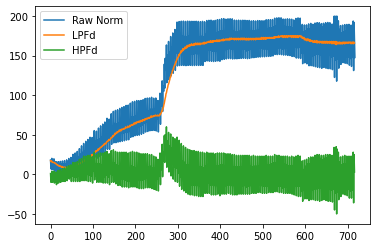

In [15]:
import matplotlib.pyplot as plt

plt.plot(din.data)
plt.plot(lpfd.data)
plt.plot(hpfd.data)

plt.legend([ din.name, lpfd.name, hpfd.name])



## Performance and Energy

In [16]:
# Read the performance counters
xh.read_perf_cnt(perf_cnt)

# Estimate the performance
xh.estimate_performance()

# Estimate the energy
xh.estimate_energy("HVT")


--- PERFORMANCE ESTIMATION AT 20MHz ---

total time:                 4.172897E-01s

x-heep

    cpu

     - active time:         4.158541E-01s
     - clock-gate time:     1.435600E-03s
     - power-gate time:     0.000000E+00s

    bus ao

     - active time:         4.172897E-01s
     - clock-gate time:     0.000000E+00s

    debug ao

     - active time:         4.172897E-01s
     - clock-gate time:     0.000000E+00s

    always-on peripheral subsystem

        soc ctrl ao

         - active time:     4.172897E-01s
         - clock-gate time: 0.000000E+00s

        boot rom ao

         - active time:     4.172897E-01s
         - clock-gate time: 0.000000E+00s

        spi flash ao

         - active time:     4.172897E-01s
         - clock-gate time: 0.000000E+00s

        spi ao

         - active time:     4.172897E-01s
         - clock-gate time: 0.000000E+00s

        power manager ao

         - active time:     4.172897E-01s
         - clock-gate time: 0.000000E+00s

        

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
df = pd.read_csv(SDK_PATH + RISCV_PATH + 'build/energy_estim.csv')

# Create a nested dictionary
energy_dict = {}
current_dict = energy_dict
for _, row in df.iterrows():
    print("row >>>", row)
    for level, value in enumerate(row):
        print("level >>>", level)
        print("value >>>", value)
        if pd.notna(value):
            current_dict[value] = {} if value not in current_dict else current_dict[value]
            current_dict = current_dict[value]

# # Plot the pie chart for the first level
# labels = list(energy_dict.keys())
# sizes = [sum(energy_dict[label].values()) for label in labels]

# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title('Energy Breakdown - First Level')
# plt.show()

row >>> module               x-heep
Unnamed: 1              NaN
Unnamed: 2              NaN
active energy           NaN
clock-gate energy       NaN
power-gate energy       NaN
retentive energy        NaN
Unnamed: 7              NaN
Name: 0, dtype: object
level >>> 0
value >>> x-heep
level >>> 1
value >>> nan
level >>> 2
value >>> nan
level >>> 3
value >>> nan
level >>> 4
value >>> nan
level >>> 5
value >>> nan
level >>> 6
value >>> nan
level >>> 7
value >>> nan
row >>> module                    NaN
Unnamed: 1                cpu
Unnamed: 2                NaN
active energy        0.000006
clock-gate energy         0.0
power-gate energy         0.0
retentive energy            -
Unnamed: 7                NaN
Name: 1, dtype: object
level >>> 0
value >>> nan
level >>> 1
value >>> cpu
level >>> 2
value >>> nan
level >>> 3
value >>> 6.44573855e-06
level >>> 4
value >>> 1.837568e-09
level >>> 5
value >>> 0.0
level >>> 6
value >>> -
level >>> 7
value >>> nan
row >>> module                    NaN